<a href="https://colab.research.google.com/github/chaghadi/ML-models/blob/main/Chap2_codes_and_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 58.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is inc

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

**Gathering** **data**

couldnt resolve Azure API key issue, return later

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY','49e30da4-500b-427d-ad09-d77b645fa744')

#key = 'da62077b-be4b-4a91-ad0a-9e45801036bc'

In [ ]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

HTTPError: 401 Client Error: PermissionDenied for url: https://api.bing.microsoft.com/v7.0/images/search?q=grizzly+bear&count=150&min_height=128&min_width=128

In [ ]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

In [ ]:
failed = verify_images(fns)
failed

In [ ]:
failed.map(Path.unlink);

**Loading** **data** "**Data** **Loaders**

In [ ]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

since resizing takes away important aspects of our pictures, we can use the following to correct it!

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

**OR**

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

**OR** Using Data Augmentation

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Training the Data

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

A handy GUI for data cleaning called ImageClassifierCleaner

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

other tasks

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

To move images for which we've selected a different category, we would run:

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

cleaning data post training

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Deployment

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

In [ ]:
learn_inf.dls.vocab

Step by Step GUI build up

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

**Get** **predictions**

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

use label to display

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

classification button

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Event Handler

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

Put in a box to complete the GUI <vertical Box>

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

Turning Notebook into App, write this on a new note book, install voila and connect it to Jupyter


In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

Important: Voilà runs Jupyter notebooks just like the Jupyter notebook server you are using now does, but it also does something very important: it removes all of the cell inputs, and only shows output (including ipywidgets), along with your markdown cells. So what's left is a web application! To view your notebook as a Voilà web application, replace the word "notebooks" in your browser's URL with: "voila/render". You will see the same content as your notebook, but without any of the code cells.

Of course, you don't need to use Voilà or ipywidgets. Your model is just a function you can call (pred,pred_idx,probs = learn.predict(img)), so you can use it with any framework, hosted on any platform. And you can take something you've prototyped in ipywidgets and Voilà and later convert it into a regular web application. We're showing you this approach in the book because we think it's a great way for data scientists and other folks that aren't web development experts to create applications from their models.

We have our app, now let's deploy it!

**Time to deploy the app**

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time, so check the book's website for the most up-to-date recommendations. As we're writing this book in early 2020 the simplest (and free!) approach is to use Binder. To publish your web app on Binder, you follow these steps:

Add your notebook to a GitHub repository.
Paste the URL of that repo into Binder's URL, as shown in <>.
Change the File dropdown to instead select URL.
In the "URL to open" field, enter /voila/render/name.ipynb (replacing name with the name of for your notebook).
Click the clickboard button at the bottom right to copy the URL and paste it somewhere safe.
Click Launch.
Deploying to Binder
The first time you do this, Binder will take around 5 minutes to build your site. Behind the scenes, it is finding a virtual machine that can run your app, allocating storage, collecting the files needed for Jupyter, for your notebook, and for presenting your notebook as a web application.

Finally, once it has started the app running, it will navigate your browser to your new web app. You can share the URL you copied to allow others to access your app as well.

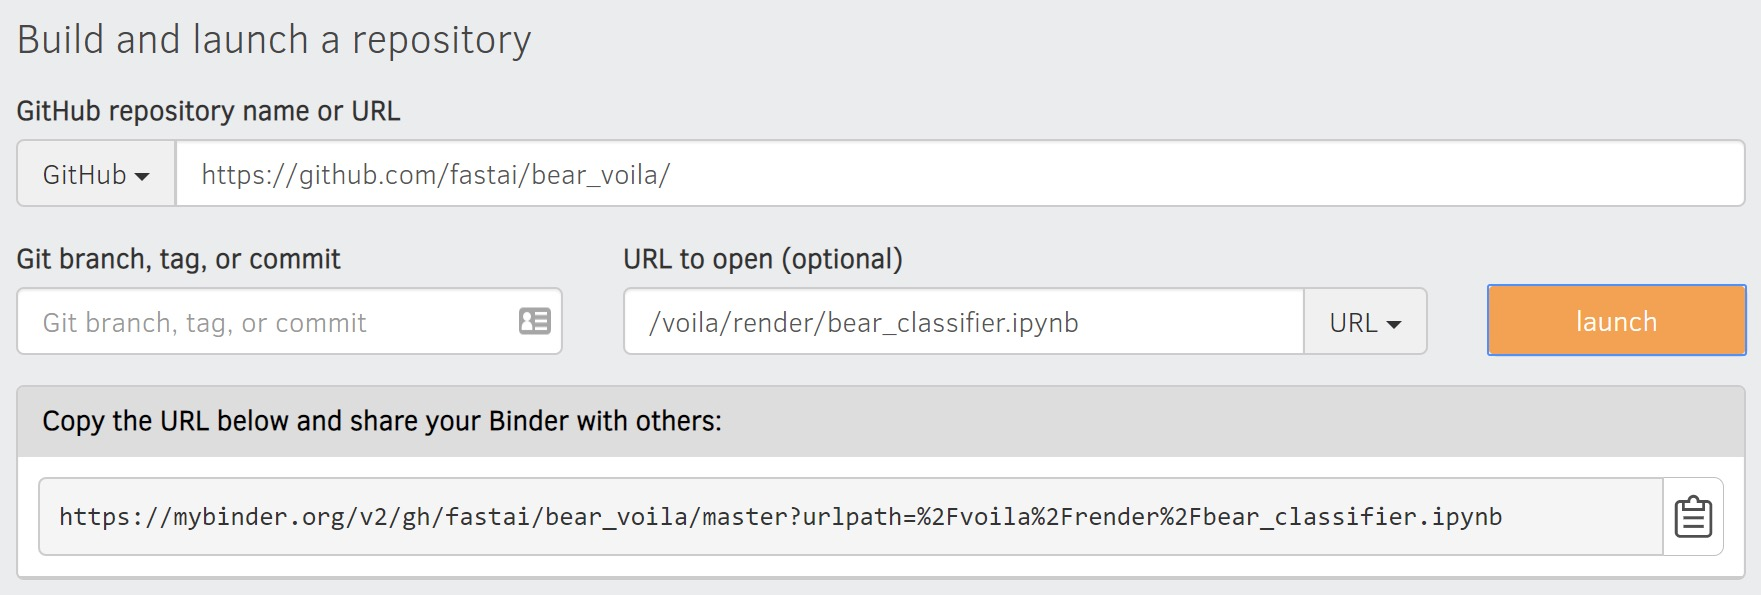